In [8]:
import functools
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import KetSugar as ks
import MaxLik as ml
import HammerProj as hp
from tqdm import tqdm_notebook

SAMPLING_KEY = 'n30'
ML_ITERS = 10000
ML_THR = 1e-12

rotations_tomo_proj = np.array((
    (0,0),
    (np.pi,0),
    (np.pi/2, 0),
    (np.pi/2, np.pi),
    (np.pi/2, 1*np.pi/2),
    (np.pi/2, 3*np.pi/2)
))

def get_assumed_rpv(errors):
    coords = rotations_tomo_proj + errors.reshape((6,2))
    proj_kets = [ks.BlochKet(theta, phi) for theta, phi in coords]
    return np.array([ket @ ket.T.conjugate() for ket in proj_kets])

def reconstruct_tomograms(error_params, tomograms = None):    
    rpv = get_assumed_rpv(error_params)
    return [ml.Reconstruct(tomogram, rpv, ML_ITERS, 1e-9, RhoPiVect = True, Renorm = True) for tomogram in tomograms]
        
butterfly = lambda x: ks.ketbra(x, x)

def rotation_y(alpha):
    return butterfly(ks.CLO) + np.exp(1j*alpha)*butterfly(ks.CHI)

def rotation_z(alpha):
    return butterfly(ks.LO) + np.exp(1j*alpha)*butterfly(ks.HI)

def find_rot(observed, ideal):
    def cost_f(args):
        y, z = args
        u = rotation_z(z) @ rotation_y(y)
        value = sum([np.abs((ks.dagger(ket_j) @ u @ ket_i)[0,0])**2 for ket_i, ket_j in zip(observed, ideal)])
        return -value
    x0 = np.random.normal(0, 0.001, 2)
    optimum = minimize(cost_f, x0 = x0)
    return optimum
    
def try_to_fix_unitary(desired_kets, observed_rhos):
    observed_kets = [np.linalg.eigh(rho)[1][:,-1].reshape((2,1)) for rho in observed_rhos]
    optimum = find_rot(observed_kets, desired_kets)
    
    y, z = optimum['x']
    try:
        assert optimum['success']
        u = rotation_z(z) @ rotation_y(y)    
        return u
    except:
        print("Ooops, unitary finding failed.")
        return np.eye(2)
    

#col 0 is index, 1 is cost function, 2...13 are optimal paramters

optim_results = np.genfromtxt('results_n30.txt')

test_data = np.load('test_data_n30_5sigma.npz')
true_parameters = test_data['truths']
tomograms = test_data['test_data']
sampling = np.load('probes_samplings.npz')[SAMPLING_KEY]
sel = optim_results[:,1] < 0.005 #select good fits
print(sum(sel)/len(sel))

0.95


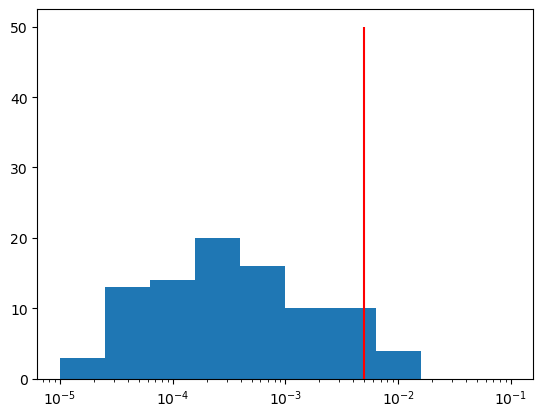

In [6]:
bins = np.logspace(-5,-1, 11)
plt.hist(optim_results[:,1], bins)
plt.gca().set_xscale('log')
plt.vlines(5e-3, 0, 50, colors='r')
plt.show()

In [9]:
selected_indices = np.arange(len(optim_results))[sel]
indices = np.random.choice(selected_indices, 4, False)
print(indices)

[51 27 24 88]


In [10]:
# Test approach on probes themselves
pur_samples = []
rhos_all = []
rhos_rotated = []
selected_test_probe_indices = [0, 5]
desired_kets = [ks.BlochKet(*sampling[i]) for i in selected_test_probe_indices]
corrective_unitaries = []

for i, (truth, tomos, result) in tqdm_notebook(enumerate(zip(true_parameters, tomograms, optim_results)), total = len(optim_results)):    
    opt_params = result[2:]
    params_list = [np.zeros(12), opt_params, truth]
    rhos_i = [reconstruct_tomograms(params, tomos) for params in params_list]    
    #calc purity
    purs = [list(map(ks.Purity, rho_list)) for rho_list in rhos_i]    
    #try to find a unitary operation that rotates observed probes back to the expected ones
    #do this for each tested ground-truth
    obs_probes_for_unitary_fix = [rhos_i[1][j] for j in selected_test_probe_indices]
    u = try_to_fix_unitary(desired_kets, obs_probes_for_unitary_fix)
    corrective_unitaries.append(u)
    #calculate "fixed" probes
    rotated_rhos = [ks.ApplyOp(rho, u) for rho in rhos_i[1]]
    rhos_i.append(rotated_rhos)    
    purs.append(purs[1])
    pur_samples.append(purs)
    rhos_all.append(np.array(rhos_i))


rhos_all = np.array(rhos_all)
pur_samples = np.array(pur_samples)

np.save('_temp_rhos_n30.npy', rhos_all)
    

C:\Users\admin\AppData\Local\Temp\ipykernel_18244\537313563.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (truth, tomos, result) in tqdm_notebook(enumerate(zip(true_parameters, tomograms, optim_results)), total = len(optim_results)):


  0%|          | 0/100 [00:00<?, ?it/s]

[98 38  2 25]


c:\Users\admin\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:4405: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


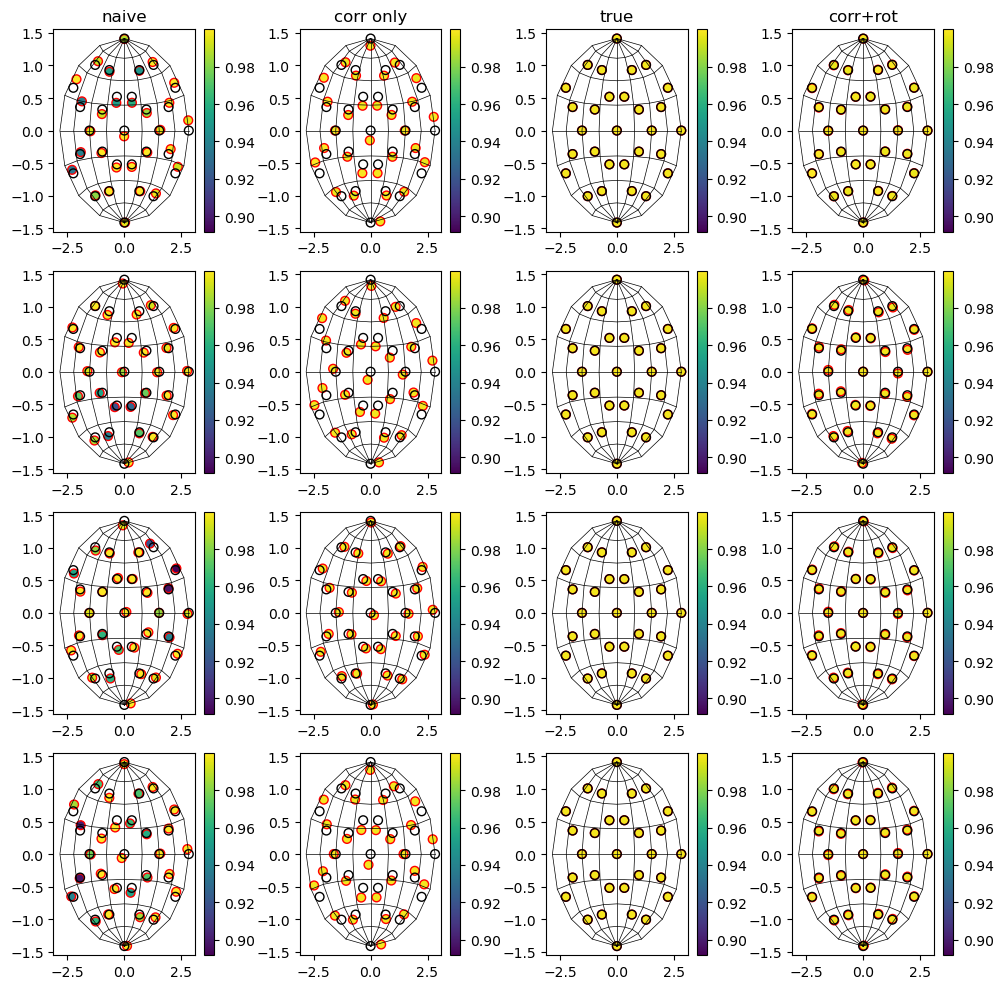

In [12]:
# Pick a few cases from the data and plot it
%matplotlib inline

mapping = lambda rho: hp.Hammer(*hp.BlochToGeo(*hp.RhoToBloch2(rho)), wrapback=True)
mapping2 = lambda coords: hp.Hammer(*hp.BlochToGeo(*coords))
i = 0

indices = np.random.choice(np.arange(len(optim_results))[sel], size=4, replace=False)
print(indices)
n = len(indices)
vmin = np.min(pur_samples[indices]).real
vmax = np.max(pur_samples[indices]).real
sampling = np.load('probes_samplings.npz')[SAMPLING_KEY]
col_labels = ['naive', 'corr only', 'true', 'corr+rot']

fig, ax = plt.subplots(n,4, figsize=(10,10))
for i, ax_line in enumerate(ax):
    #columns are: naive, corrected, true, corrected & transformed
    for j, ax_col in enumerate(ax_line):        
        hp.PlotHammerGrid(ax_col, 9, 9)
        i_mapped = indices[i]
        xy = np.array(list(map(mapping, rhos_all[i_mapped,j,:,:])))        
        xy_s = np.array(list(map(mapping2, sampling)))
        im = ax_col.scatter(xy[:,0], xy[:,1], s=40, c=pur_samples[i_mapped,j,:], vmin=vmin, vmax=vmax, edgecolors='r')
        #im = ax_col.scatter(xy[:,0], xy[:,1], s=40, c=pur_samples[i_mapped,j,:])
        ax_col.scatter(xy_s[:,0], xy_s[:,1], s=40, edgecolors='k', facecolors='none')
        fig.colorbar(im, ax=ax_col)
        if i==0:
            ax_col.set_title(col_labels[j])

plt.tight_layout()
plt.show()

In [15]:
# Produce artifically more tomograms (of more probe states) with the ground-truth taken into account,
# then reconstruct them (a) naively (assuming no errors), (b) with estimated parameters taken into account, (c) using ground truth
# the result reconstued with estimated parameters are then also rotated using the found unitary operation
# Warning: this is costly, maybe you can load the saved data instead if you are in hurry.
TEST_KEY_SAMPLING = 'n108' #dense test
sampling = np.load('probes_samplings.npz')[TEST_KEY_SAMPLING]

pur_samples_d = []
rhos_all_d = []
for i, (truth, result) in tqdm_notebook(enumerate(zip(true_parameters, optim_results)), total = len(optim_results)):    
    true_rpv = get_assumed_rpv(truth)
    tomos = []
    for theta, phi in sampling:
        ket = ks.BlochKet(theta, phi)
        tomogram = np.array([ks.ExpectationValue(ket, pi) for pi in true_rpv])
        tomos.append(tomogram)
    tomos = np.array(tomos)

    opt_params = result[2:]
    params_list = [np.zeros(12), opt_params, truth]
    rhos_i = [reconstruct_tomograms(params, tomos) for params in params_list]
    rhos_rot = [ks.ApplyOp(rho, corrective_unitaries[i]) for rho in rhos_i[1]]
    rhos_i.append(rhos_rot)

    rhos_all_d.append(np.array(rhos_i))
    #calc purity
    purs = [list(map(ks.Purity, rho_list)) for rho_list in rhos_i]
    pur_samples_d.append(purs)

rhos_all_d = np.array(rhos_all_d)
pur_samples_d = np.array(pur_samples_d)

np.save('_temp_rhos_n108_test.npy', rhos_all)

C:\Users\admin\AppData\Local\Temp\ipykernel_18244\1273301069.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (truth, result) in tqdm_notebook(enumerate(zip(true_parameters, optim_results)), total = len(optim_results)):


  0%|          | 0/100 [00:00<?, ?it/s]

[98 38  2 25]


c:\Users\admin\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:4405: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


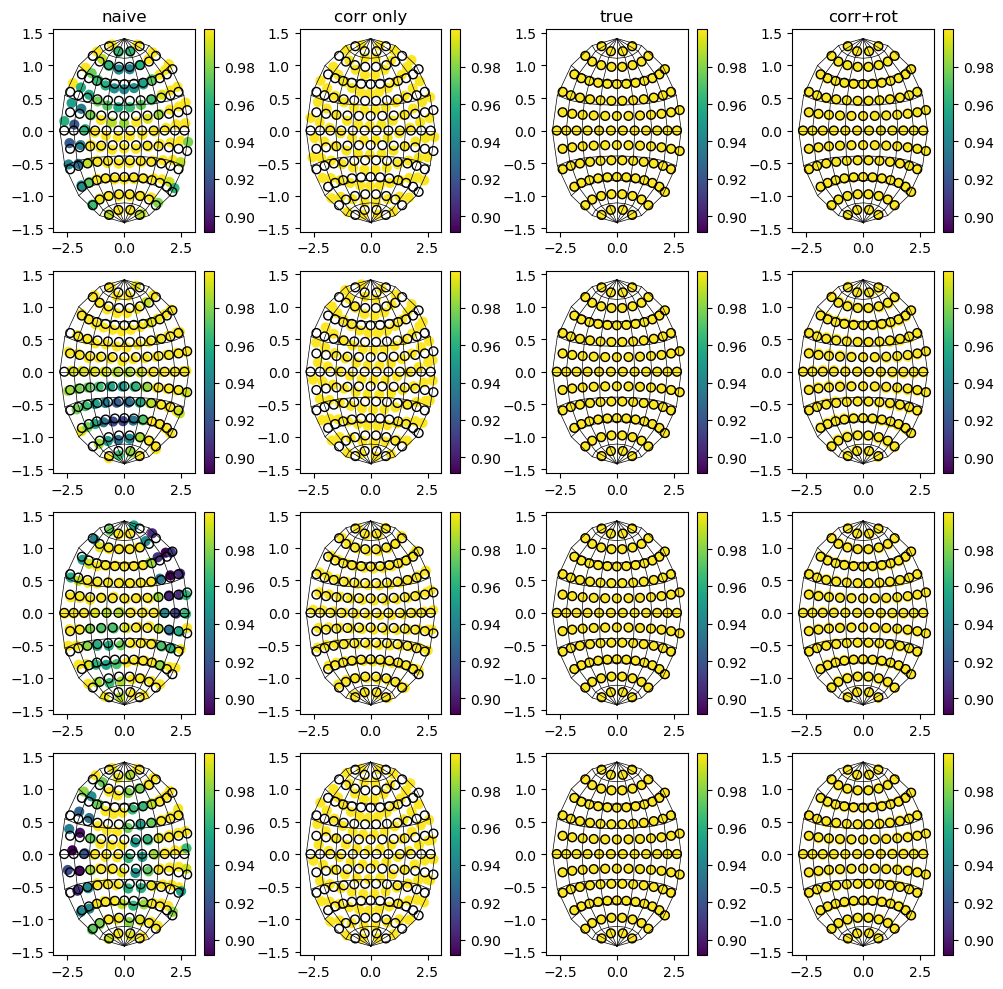

In [16]:
# Pick a few cases from the data and plot it
%matplotlib inline

i = 0
#indices = np.random.choice(np.arange(len(optim_results))[sel], size=4, replace=False)
print(indices)
n = len(indices)
vmin = np.min(pur_samples[indices]).real
vmax = np.max(pur_samples[indices]).real
sampling = np.load('probes_samplings.npz')[TEST_KEY_SAMPLING]
col_labels = ['naive', 'corr only', 'true', 'corr+rot']

fig, ax = plt.subplots(n,4, figsize=(10,10))
for i, ax_line in enumerate(ax):
    #columns are: naive, corrected, true, corrected & transformed
    for j, ax_col in enumerate(ax_line):        
        hp.PlotHammerGrid(ax_col, 9, 9)
        i_mapped = indices[i]
        xy = np.array(list(map(mapping, rhos_all_d[i_mapped,j,:,:])))        
        xy_s = np.array(list(map(mapping2, sampling)))
        im = ax_col.scatter(xy[:,0], xy[:,1], s=40, c=pur_samples_d[i_mapped,j,:], vmin=vmin, vmax=vmax)
        #im = ax_col.scatter(xy[:,0], xy[:,1], s=40, c=pur_samples[i_mapped,j,:])
        ax_col.scatter(xy_s[:,0], xy_s[:,1], s=40, edgecolors='k', facecolors='none')
        fig.colorbar(im, ax=ax_col)
        if i==0:
            ax_col.set_title(col_labels[j])

plt.tight_layout()
plt.show()

In [17]:
#to do: introduce a measure of matching (fidelity)
#and evaluate it on the whole enseble, then plot the results
#for example cost function vs. fidelity

#rhos_all_d contains all test reconstruction, rhos_all_d[:,-1,:,:] the ones which are rotated
#rhos_all_d[:,-2,:,:] contains the grount truths

#for r in rhos_all_d:
rhos_all_d.shape

fidelities = []
for dataset_n, dataset_c, dataset_t, dataset_uc in rhos_all_d:
    sub_fidelities = []
    for rho_true, rho_c, rho_uc, rho_n in zip(dataset_t, dataset_c, dataset_uc, dataset_n):
        fn = ks.Fidelity(rho_true, rho_n)
        pn = ks.Purity(rho_n)
        fc = ks.Fidelity(rho_true, rho_c)
        pc = ks.Purity(rho_c)
        fuc = ks.Fidelity(rho_true, rho_uc)
        sub_fidelities.append((fc, fuc, fn, pn, pc))
    fidelities.append(sub_fidelities)

fidelities = np.array(fidelities)

0.95


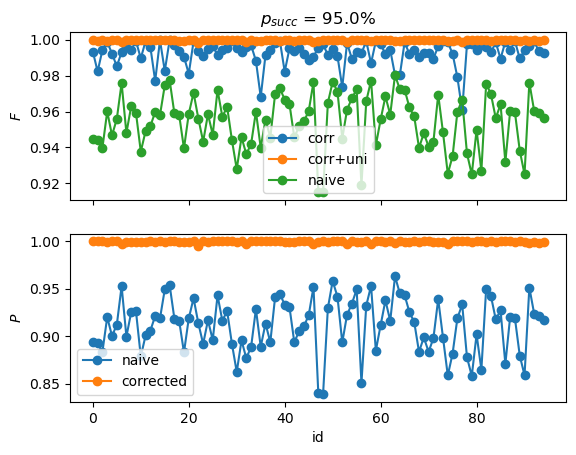

In [30]:
#purities and fidelities are given as worst case over test ensemble
sel = optim_results[:,1]<0.005 #select only cases where the Nomad finished successfully
#sel = optim_results[:,1]<0.1
print(sum(sel)/len(sel))
fs = np.min(fidelities, axis=1)
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(fs[sel,0], "o-", label = 'corr') #fidelity corrected
ax[0].plot(fs[sel,1], "o-", label = 'corr+uni') #fidelity unitary rotated
ax[0].plot(fs[sel,2], "o-", label = 'naive') #fidelity naive
ax[1].plot(fs[sel,3], "o-", label = 'naive') #purity naive
ax[1].plot(fs[sel,4], "o-", label = 'corrected') #purity corrected
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel("$F$")
ax[1].set_ylabel("$P$")
ax[1].set_xlabel("id")
ax[0].set_title(f'$p_{{succ}}$ = {100*sum(sel)/len(sel):.1f}%')
plt.show()


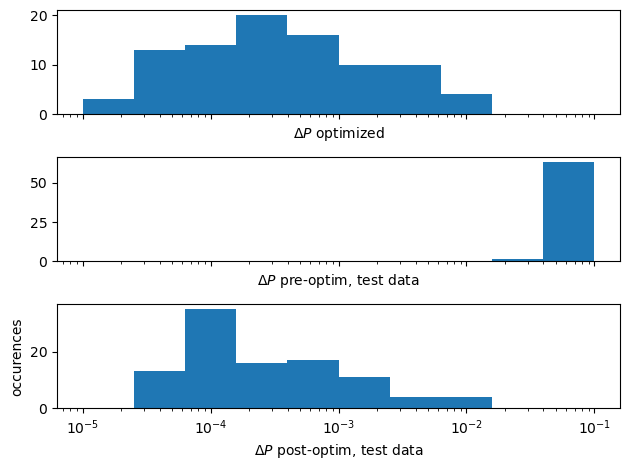

In [31]:
bins = np.logspace(-5,-1, 11)
fig, ax = plt.subplots(3,1, sharex=True)
ax[0].hist(optim_results[:,1], bins=bins)
ax[1].hist(np.ptp(fidelities[:,:,-2], axis=1), bins=bins)
ax[2].hist(np.ptp(fidelities[:,:,-1], axis=1), bins=bins)
ax[0].set_xscale("log")
ax[0].set_xlabel("$\Delta P$ optimized")
ax[1].set_xlabel("$\Delta P$ pre-optim, test data")
ax[2].set_xlabel("$\Delta P$ post-optim, test data")
ax[2].set_ylabel("occurences")
plt.tight_layout()
plt.show()

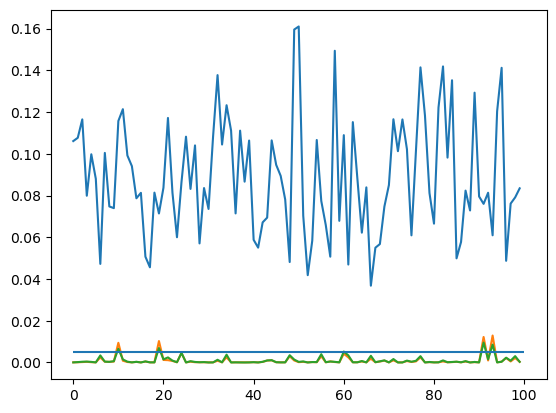

In [32]:
%matplotlib inline
#fidelities[fidelities,-2]
a = np.ptp(fidelities[:,:,-2], axis=1)
b = np.ptp(fidelities[:,:,-1], axis=1)
plt.plot(a)
plt.plot(b)
plt.plot(optim_results[:,1])
plt.hlines([5e-3], 0, 100)
plt.show()


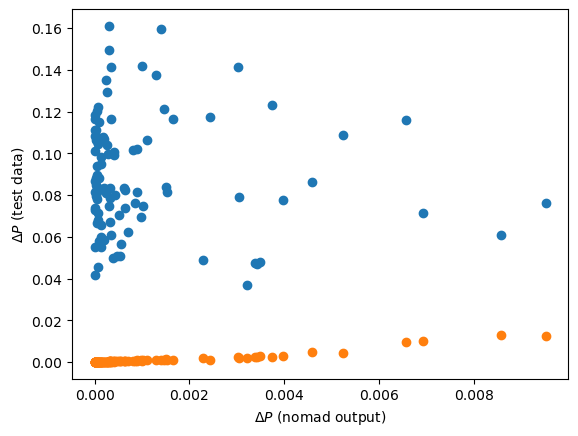

In [33]:
plt.scatter(optim_results[:,1], a, label='pre-optim')
plt.scatter(optim_results[:,1], b, label='post-optim')
plt.ylabel('$\Delta P$ (test data)')
plt.xlabel('$\Delta P$ (nomad output)')
plt.show()

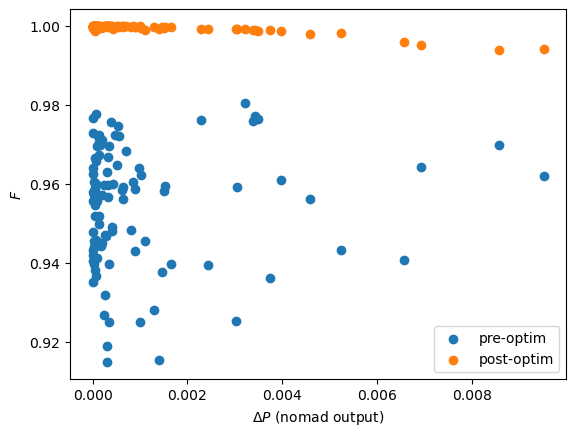

0
0.0 % faults


In [34]:
plt.scatter(optim_results[:,1], np.min(fidelities[:,:,2], axis=1), label='pre-optim')
plt.scatter(optim_results[:,1], np.min(fidelities[:,:,1], axis=1), label='post-optim')
plt.ylabel('$F$')
plt.xlabel('$\Delta P$ (nomad output)')
plt.legend()
#plt.scatter(optim_results[:,1], fid_diff)
plt.show()

#np.min(fidelities[:,:,2], axis=1) < 0
fid_diff = np.min(fidelities[:,:,1], axis=1)-np.min(fidelities[:,:,2], axis=1)
sel_fault = fid_diff < 0
faults = sum(sel_fault)
print(faults)
print(100*faults/fidelities.shape[0], "% faults")